## Projet 6 - Analysez les ventes d'une librairie avec R ou Python

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import exp, sqrt, pi
from IPython.display import display

## Partie 1 : Nettoyage et vérification des Dataframes

In [2]:
customer = pd.read_csv("customers.csv")
customer.shape

(8623, 3)

In [3]:
product = pd.read_csv("products.csv")
product.shape

(3287, 3)

In [4]:
transaction = pd.read_csv("transactions.csv")
transaction.shape

(679532, 4)

**On vérifie l'unicité des clés 'client_id' et 'id_prod' dans les dataframes respectifs customer et product**

In [5]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def testUnicity(df, column):
    if pd.Series(df[column]).is_unique:
        print("Only Unique Values in the column : "+column+" from "+get_df_name(df))
    else: 
        print("No Unique Values in the column : "+column+" from "+get_df_name(df))
    print("Dataframe shape : "+str(df.shape)+" (Rows, Columns)")

In [6]:
testUnicity(customer, 'client_id')
testUnicity(product, 'id_prod')

Only Unique Values in the column : client_id from customer
Dataframe shape : (8623, 3) (Rows, Columns)
Only Unique Values in the column : id_prod from product
Dataframe shape : (3287, 3) (Rows, Columns)


In [7]:
# Nous nettoyons les 3 dataframes des valeurs NULL

def my_drop_na() :
    table_df = [customer, product, transaction]
    for x in table_df:
        print(get_df_name(x))
        print("AVANT: ", x.shape)
        x = x.dropna()
        print("APRES: ", x.shape)
        print("\n")

my_drop_na()

customer
AVANT:  (8623, 3)
APRES:  (8623, 3)


product
AVANT:  (3287, 3)
APRES:  (3287, 3)


transaction
AVANT:  (679532, 4)
APRES:  (679532, 4)




**On vérifie les valeurs aberrantes possibles dans chaque dataframe**

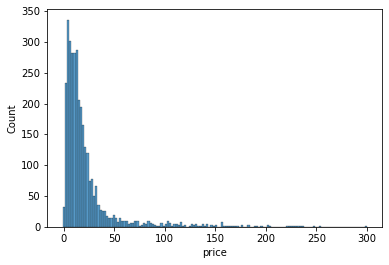

In [8]:
# Dans le dataframe 'product', on regarde s'il n'existe pas de valeurs aberrantes au niveau du prix
# (ex: valeurs négatives)

sns.histplot(product['price'])

In [9]:
product_temp = product[product['price'] <= 0]
product_temp.head()

,id_prod,price,categ
731,T_0,-1.0,0


In [10]:
# On supprimer le produit yant pour id_prod(T_0) et comme valeur price(-1)

product_new = product[product['id_prod'] != 'T_0']
product_temp = product_new[product_new['price'] <= 0]
product_temp.head()

,id_prod,price,categ


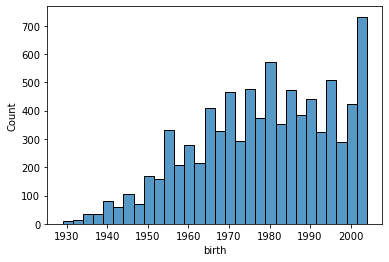

In [11]:
# Dans le dataframe 'customer', on regarde s'il n'existe pas de valeurs aberrantes au niveau des dates
# (ex: dates de naissance supérieures à aujourd'hui)

sns.histplot(customer['birth'])

In [12]:
customer_temp = customer[customer['birth'] >= 2022]
customer_temp.head()

,client_id,sex,birth


In [13]:
# Verifions maintenant que le produit(T_0) n'apparait pas dans la liste des transactions

transaction_temp = transaction[transaction['id_prod'] == 'T_0']
display(transaction_temp.head())
display(transaction_temp.shape)

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0


(200, 4)

In [23]:
# Il s'agit de transactions de test. Je prends la décision ici de ne pas les prendre en compte
# pour la suite des analyses

transaction_new = transaction[transaction['id_prod'] != 'T_0']
transaction_temp = transaction_new[transaction_new['id_prod'] == 'T_0']
transaction_temp.head()

,id_prod,date,session_id,client_id


In [24]:
# Nous modifions le format de date de transaction pour qu'il soit lisible et exploitable

transaction_new.loc[:, 'date'] = pd.to_datetime(transaction_new.date)
transaction_new.loc[:, 'n_date'] = transaction_new.loc[:, 'date'].dt.strftime('%d/%m/%Y_%H:%M:%S')
transaction_new = transaction_new.drop(['date'], axis=1)
transaction_new.head()

,id_prod,session_id,client_id,n_date
0,0_1518,s_211425,c_103,20/05/2022_13:21:29
1,1_251,s_158752,c_8534,02/02/2022_07:55:19
2,0_1277,s_225667,c_6714,18/06/2022_15:44:33
3,2_209,s_52962,c_6941,24/06/2021_04:19:29
4,0_1509,s_325227,c_4232,11/01/2023_08:22:08


In [25]:
# Nous allons vérifier que chaque transaction est unique avec l'id_prod, le client_id et la date

temp = transaction_new
temp['combined'] = transaction_new['id_prod'] +'_'+ transaction_new['client_id'] +'_'+ transaction_new['n_date']
temp.head()

,id_prod,session_id,client_id,n_date,combined
0,0_1518,s_211425,c_103,20/05/2022_13:21:29,0_1518_c_103_20/05/2022_13:21:29
1,1_251,s_158752,c_8534,02/02/2022_07:55:19,1_251_c_8534_02/02/2022_07:55:19
2,0_1277,s_225667,c_6714,18/06/2022_15:44:33,0_1277_c_6714_18/06/2022_15:44:33
3,2_209,s_52962,c_6941,24/06/2021_04:19:29,2_209_c_6941_24/06/2021_04:19:29
4,0_1509,s_325227,c_4232,11/01/2023_08:22:08,0_1509_c_4232_11/01/2023_08:22:08


In [26]:
testUnicity(temp, 'combined')
print("Nb de doublons dans la colonne 'combined' : ", temp.duplicated(subset=['combined']).sum())

Only Unique Values in the column : combined from transaction_new
Dataframe shape : (679332, 5) (Rows, Columns)
Nb de doublons dans la colonne 'combined' :  0


In [27]:
print(transaction_new.head())
transaction_new = transaction_new.drop(['combined'], axis=1)
transaction_new.head()

  id_prod session_id client_id               n_date  \
0  0_1518   s_211425     c_103  20/05/2022_13:21:29   
1   1_251   s_158752    c_8534  02/02/2022_07:55:19   
2  0_1277   s_225667    c_6714  18/06/2022_15:44:33   
3   2_209    s_52962    c_6941  24/06/2021_04:19:29   
4  0_1509   s_325227    c_4232  11/01/2023_08:22:08   

                            combined  
0   0_1518_c_103_20/05/2022_13:21:29  
1   1_251_c_8534_02/02/2022_07:55:19  
2  0_1277_c_6714_18/06/2022_15:44:33  
3   2_209_c_6941_24/06/2021_04:19:29  
4  0_1509_c_4232_11/01/2023_08:22:08  


,id_prod,session_id,client_id,n_date
0,0_1518,s_211425,c_103,20/05/2022_13:21:29
1,1_251,s_158752,c_8534,02/02/2022_07:55:19
2,0_1277,s_225667,c_6714,18/06/2022_15:44:33
3,2_209,s_52962,c_6941,24/06/2021_04:19:29
4,0_1509,s_325227,c_4232,11/01/2023_08:22:08


**Dernières verifications et jointures des dataframes**

In [28]:
# On peut maintenant joindre les 3 dataframes ensemble en gardant un oeil sur des valeurs NULL, NaN ou inexistantes
# Nos 3 dataframes sont : customer, product_new, transaction_new

prod_transac = product_new.merge(transaction_new, on='id_prod', how='outer', indicator=True)
prod_transac.head()

,id_prod,price,categ,session_id,client_id,n_date,_merge
0,0_1421,19.99,0.0,s_168213,c_6389,20/02/2022_17:04:37,both
1,0_1421,19.99,0.0,s_299590,c_8364,19/11/2022_03:42:20,both
2,0_1421,19.99,0.0,s_92304,c_3544,19/09/2021_14:58:46,both
3,0_1421,19.99,0.0,s_325369,c_1025,11/01/2023_16:04:24,both
4,0_1421,19.99,0.0,s_70071,c_2298,01/08/2021_19:33:18,both


In [29]:
# On vérifie que la jointure est complète (_merge = both) pour toutes les valeurs du dataframe prod_transac

prod_transac_temp = prod_transac[prod_transac['_merge'] != 'both']
display(prod_transac_temp.shape)
prod_transac_temp.head()

(242, 7)

,id_prod,price,categ,session_id,client_id,n_date,_merge
39705,0_1016,35.06,0.0,NaN,NaN,NaN,left_only
62805,0_1780,1.67,0.0,NaN,NaN,NaN,left_only
162765,0_1062,20.08,0.0,NaN,NaN,NaN,left_only
177522,0_1119,2.99,0.0,NaN,NaN,NaN,left_only
181172,0_1014,1.15,0.0,NaN,NaN,NaN,left_only


In [30]:
# Il existe donc 242 valeurs dont la jointure n'est pas complète (left_only et right_only)
# Verifions ces valeurs afin de determiner si elles sont exploitables ou non

temp_left = prod_transac_temp[prod_transac_temp['_merge'] == 'left_only']
display(temp_left.shape)
temp_left.head()

(21, 7)

,id_prod,price,categ,session_id,client_id,n_date,_merge
39705,0_1016,35.06,0.0,NaN,NaN,NaN,left_only
62805,0_1780,1.67,0.0,NaN,NaN,NaN,left_only
162765,0_1062,20.08,0.0,NaN,NaN,NaN,left_only
177522,0_1119,2.99,0.0,NaN,NaN,NaN,left_only
181172,0_1014,1.15,0.0,NaN,NaN,NaN,left_only


In [31]:
temp_right = prod_transac_temp[prod_transac_temp['_merge'] == 'right_only']
display(temp_right.shape)
temp_right.head()

(221, 7)

,id_prod,price,categ,session_id,client_id,n_date,_merge
679132,0_2245,NaN,NaN,s_272266,c_4746,23/09/2022_07:22:38,right_only
679133,0_2245,NaN,NaN,s_242482,c_6713,23/07/2022_09:24:14,right_only
679134,0_2245,NaN,NaN,s_306338,c_5108,03/12/2022_03:26:35,right_only
679135,0_2245,NaN,NaN,s_76493,c_1391,16/08/2021_11:33:25,right_only
679136,0_2245,NaN,NaN,s_239078,c_7954,16/07/2022_05:53:01,right_only


In [32]:
# 21 produits n'ont pas de données sur leurs transactions
# 221 produits n'ont pas d'informations de prix et de catégorie
# Ces données ne sont donc pas exploitables, nous ne garderons que les valeurs dont la jointure est complète

prod_transac_new = prod_transac[prod_transac['_merge'] == 'both']
temp = prod_transac_new[prod_transac_new['_merge'] != 'both']
temp.head()

,id_prod,price,categ,session_id,client_id,n_date,_merge


In [33]:
# On supprime la colonne '_merge' qui ne nous sera pas utile pour la suite 

prod_transac_new = prod_transac_new.drop(['_merge'], axis=1)
prod_transac_new.head()

,id_prod,price,categ,session_id,client_id,n_date
0,0_1421,19.99,0.0,s_168213,c_6389,20/02/2022_17:04:37
1,0_1421,19.99,0.0,s_299590,c_8364,19/11/2022_03:42:20
2,0_1421,19.99,0.0,s_92304,c_3544,19/09/2021_14:58:46
3,0_1421,19.99,0.0,s_325369,c_1025,11/01/2023_16:04:24
4,0_1421,19.99,0.0,s_70071,c_2298,01/08/2021_19:33:18


In [34]:
# On peut maintenant joindre les 2 dataframes : customer et prod_transac_new

complete_df = prod_transac_new.merge(customer, on='client_id', how='outer', indicator=True)
complete_df.head()

,id_prod,price,categ,session_id,client_id,n_date,sex,birth,_merge
0,0_1421,19.99,0.0,s_168213,c_6389,20/02/2022_17:04:37,f,1991,both
1,0_1421,19.99,0.0,s_285450,c_6389,20/10/2022_17:04:37,f,1991,both
2,0_2131,8.99,0.0,s_102458,c_6389,09/10/2021_21:47:06,f,1991,both
3,0_1635,16.99,0.0,s_26841,c_6389,28/04/2021_06:08:38,f,1991,both
4,0_166,1.83,0.0,s_62585,c_6389,15/07/2021_10:35:31,f,1991,both


In [35]:
# Même vérification que sur la jointure précdente pour s'assurer qu'elle est complète

print("Shape du dataframe complete_df :                 ", complete_df.shape)
temp_complete = complete_df[complete_df['_merge'] == 'both']
print("Shape du dataframe complete_df['_merge'] = both :", temp_complete.shape)

Shape du dataframe complete_df :                  (679134, 9)
Shape du dataframe complete_df['_merge'] = both : (679111, 9)


In [36]:
# Il y a donc une différence de 23 lignes
# Identifions les

temp_right = complete_df[complete_df['_merge'] == 'right_only']
display(temp_right.shape)
temp_right.head()

(23, 9)

,id_prod,price,categ,session_id,client_id,n_date,sex,birth,_merge
679111,NaN,NaN,NaN,NaN,c_8253,NaN,f,2001,right_only
679112,NaN,NaN,NaN,NaN,c_3789,NaN,f,1997,right_only
679113,NaN,NaN,NaN,NaN,c_4406,NaN,f,1998,right_only
679114,NaN,NaN,NaN,NaN,ct_0,NaN,f,2001,right_only
679115,NaN,NaN,NaN,NaN,c_2706,NaN,f,1967,right_only


In [37]:
# Ces clients n'ont pas de données de transactions, nous pouvons les supprimer du dataframe

complete_df = complete_df[complete_df['_merge'] == 'both']
complete_df = complete_df.drop(['_merge'], axis=1)
complete_df.head()

,id_prod,price,categ,session_id,client_id,n_date,sex,birth
0,0_1421,19.99,0.0,s_168213,c_6389,20/02/2022_17:04:37,f,1991
1,0_1421,19.99,0.0,s_285450,c_6389,20/10/2022_17:04:37,f,1991
2,0_2131,8.99,0.0,s_102458,c_6389,09/10/2021_21:47:06,f,1991
3,0_1635,16.99,0.0,s_26841,c_6389,28/04/2021_06:08:38,f,1991
4,0_166,1.83,0.0,s_62585,c_6389,15/07/2021_10:35:31,f,1991


In [38]:
# Nous avons à présent un dataframe complet et nettoyer : complete_df
# Il regroupe les données dont nous avons besoin pour les prochaines analyse
# les données : clients, produits et transactionnels

## Analyses demandées par Antoine et Julie

In [39]:
# Afin de pouvoir exploiter au mieux les informations liées à la colonne n_date
# Nous décidons de séparer l'heure et la date dans 2 colonnes distinctes

complete_df[['date', 'time']] = complete_df['n_date'].str.split('_', 1, expand=True)
complete_df = complete_df.drop(['n_date'], axis=1)
complete_df.head()

,id_prod,price,categ,session_id,client_id,sex,birth,date,time
0,0_1421,19.99,0.0,s_168213,c_6389,f,1991,20/02/2022,17:04:37
1,0_1421,19.99,0.0,s_285450,c_6389,f,1991,20/10/2022,17:04:37
2,0_2131,8.99,0.0,s_102458,c_6389,f,1991,09/10/2021,21:47:06
3,0_1635,16.99,0.0,s_26841,c_6389,f,1991,28/04/2021,06:08:38
4,0_166,1.83,0.0,s_62585,c_6389,f,1991,15/07/2021,10:35:31


In [40]:
complete_df.to_csv('complete.csv')